In [1]:
import sys
sys.path.append('../src')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from time import time

from instance import Instance
from sweep import sweep
from cost import cost

First we choose an instance to work on

In [2]:
I = Instance(
    instance_dir='../data/raw',
    instance='n120_s04_t01_w01'
)

Let's see what it looks like

In [3]:
G = nx.Graph()
for i in range(I.n+1): G.add_node(i, pos=I.nodes[i])
pos = nx.get_node_attributes(G, 'pos')

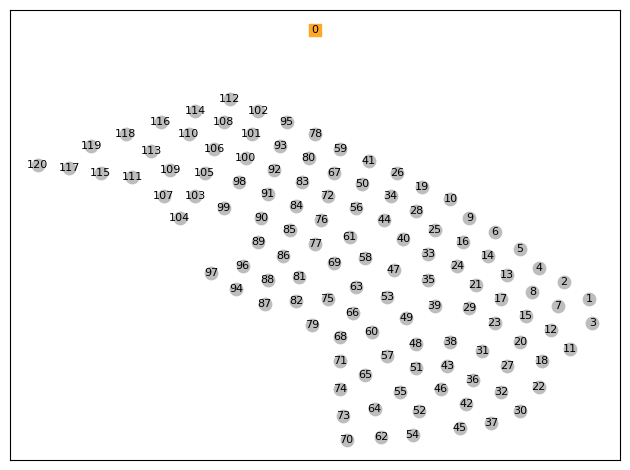

In [4]:
nx.draw_networkx_nodes(G, pos,
                       nodelist=[0],
                       node_color='#FFA726',
                       node_size=80,
                       node_shape='s')
nx.draw_networkx_nodes(G, pos,
                       nodelist=range(1, I.n+1),
                       node_color='#BDBDBD',
                       node_size=80)
nx.draw_networkx_labels(G, pos,
                        font_size=8)
plt.tight_layout()
plt.show()

Let's run sweep with arbitrary parameters first

In [5]:
solution = sweep(I,
      starting_turbine=10,
      clockwise=False,
      tpg=20)

Let's see what it looks like

/tmp/ipykernel_22941/1148517937.py:10: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos,


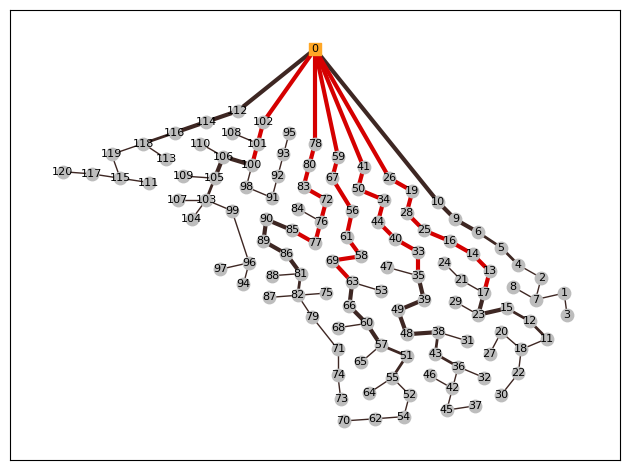

In [6]:
nx.draw_networkx_nodes(G, pos,
                       nodelist=[0],
                       node_color='#FFA726',
                       node_size=80,
                       node_shape='s')
nx.draw_networkx_nodes(G, pos,
                       nodelist=range(1, I.n+1),
                       node_color='#BDBDBD',
                       node_size=80)
nx.draw_networkx_edges(G, pos,
                       edgelist=[[x[0][0], x[0][1]] for x in solution],
                       edge_color=['#3E2723' if x[1]>=0 else '#D50000' for x in solution],
                       width=[x[1]+1 if x[1]>=0 else len(I.cables) for x in solution])
nx.draw_networkx_labels(G, pos,
                        font_size=8)
plt.tight_layout()
plt.show()

The width of cable represent its capacity. A red one means overflow.

Let's run sweep over all possibilities.

Since sweep always creates a proper tree without cable crossings, we can run cost with simple=True. Otherwise, it could take a long time to run all the possibilities (800 seconds on average in case of 120 turbines).

To optimize even further, we can run TPG between n/C and max_cable_capacity/avg_power as described in paper.

In [7]:
t = time()
solutions = []
for starting_turbine in range(1, I.n+1):
    for clockwise in [True, False]:
        for tpg in range(I.n//I.C, I.cables[-1]['capacity']+1):
            solutions.append([
                starting_turbine,
                clockwise,
                tpg,
                sweep(I, starting_turbine, clockwise, tpg)])
for sol in solutions:
    sol.append(cost(I, sol[-1], simple=True))
print(f'Took {round(time()-t, 1)}s')

Took 0.6s


In [8]:
solutions_df = pd.DataFrame(solutions, columns=['starting_turbine', 'clockwise', 'tpg', 'solution', 'cost'])
solutions_df = solutions_df.sort_values('cost')
solutions_df = solutions_df.reset_index()
solutions_df

,index,starting_turbine,clockwise,tpg,solution,cost
0,650,109,True,12,"[[(9, 10), 2], [(6, 9), 2], [(5, 6), 2], [(4, ...",8.812865e+07
1,362,61,True,12,"[[(9, 10), 2], [(6, 9), 2], [(5, 6), 2], [(4, ...",8.812865e+07
2,506,85,True,12,"[[(9, 10), 2], [(6, 9), 2], [(5, 6), 2], [(4, ...",8.812865e+07
3,218,37,True,12,"[[(9, 10), 2], [(6, 9), 2], [(5, 6), 2], [(4, ...",8.812865e+07
4,290,49,True,12,"[[(9, 10), 2], [(6, 9), 2], [(5, 6), 2], [(4, ...",8.812865e+07
...,...,...,...,...,...,...
715,63,11,False,10,"[[(114, 112), 2], [(116, 114), 1], [(118, 116)...",2.101485e+09
716,243,41,False,10,"[[(114, 112), 2], [(116, 114), 1], [(118, 116)...",2.101485e+09
717,246,42,True,10,"[[(9, 10), 2], [(6, 9), 2], [(5, 6), 1], [(4, ...",2.101485e+09
718,423,71,False,10,"[[(114, 112), 2], [(116, 114), 1], [(118, 116)...",2.101485e+09


Plotting the costs in ascending order gives this graph

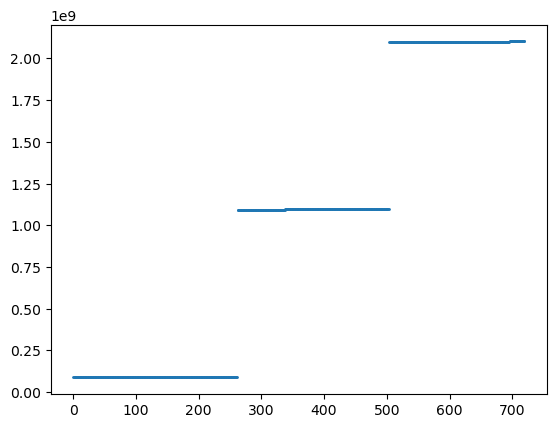

In [9]:
plt.scatter(solutions_df.index, solutions_df['cost'], s=1)
plt.show()

### Best solution

#### Best parameters

In [10]:
print(solutions_df.loc[0,['starting_turbine', 'clockwise', 'tpg', 'cost']])

starting_turbine                109
clockwise                      True
tpg                              12
cost                88128651.744213
Name: 0, dtype: object


#### Graph

/tmp/ipykernel_22941/545776659.py:10: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos,


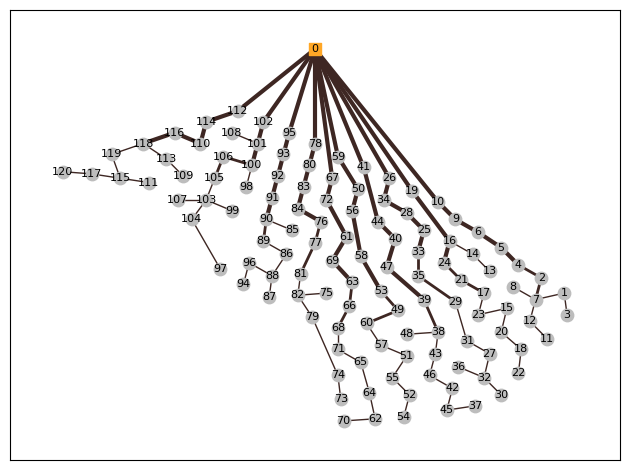

In [11]:
nx.draw_networkx_nodes(G, pos,
                       nodelist=[0],
                       node_color='#FFA726',
                       node_size=80,
                       node_shape='s')
nx.draw_networkx_nodes(G, pos,
                       nodelist=range(1, I.n+1),
                       node_color='#BDBDBD',
                       node_size=80)
nx.draw_networkx_edges(G, pos,
                       edgelist=[[x[0][0], x[0][1]] for x in solutions_df['solution'][0]],
                       edge_color=['#3E2723' if x[1]>=0 else '#D50000' for x in solutions_df['solution'][0]],
                       width=[x[1]+1 if x[1]>=0 else len(I.cables) for x in solutions_df['solution'][0]])
nx.draw_networkx_labels(G, pos,
                        font_size=8)
plt.tight_layout()
plt.show()